In [1]:
import pandas as pd
from catboost import CatBoostRegressor
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso

from src.utils import prediction_on_folds, train_nocv, compute_metrics_by_method
from src.outputs import save_fold_predictions, save_nofolds_predictions
from src.manipulations import categorical_features
from src.labels_paper import labels

import os
from src.consts import DATADIRECTORY

# Read data

### Read data for implicit substrates

In [2]:
df = pd.read_csv(os.path.join(DATADIRECTORY,'implicit_dataset.csv'))
pt = pd.read_csv(os.path.join(DATADIRECTORY,'implicit_PT.csv'))
target = pd.read_csv(os.path.join(DATADIRECTORY,'implicit_target_mae.csv'))
target_soc = pd.read_csv(os.path.join(DATADIRECTORY,'implicit_target_soc.csv'))
target_socm = pd.read_csv(os.path.join(DATADIRECTORY,'implicit_target_socm.csv'))

# add PT as one of possible features
df = pd.concat([df, pt], axis=1)

In [3]:
print(f'Total number of features: {len(df.columns)}')
print(f'Total number of systems: {len(df)}')

Total number of features: 154
Total number of systems: 806


### Read data for explicit substrates

In [4]:
df_es = pd.read_csv(os.path.join(DATADIRECTORY,'explicit_dataset.csv'))
pt_es = pd.read_csv(os.path.join(DATADIRECTORY,'explicit_PT.csv'))
target_es = pd.read_csv(os.path.join(DATADIRECTORY,'explicit_target_mae.csv'))
target_soc_es = pd.read_csv(os.path.join(DATADIRECTORY,'explicit_target_soc.csv'))
target_socm_es = pd.read_csv(os.path.join(DATADIRECTORY,'explicit_target_socm.csv'))

# add PT as one of possible features
df_es = pd.concat([df_es, pt_es], axis=1)

In [5]:
print(f'Total number of features: {len(df_es.columns)}')
print(f'Total number of systems: {len(df_es)}')

Total number of features: 154
Total number of systems: 15


In [6]:
# prepare data for LinearRegression and Lasso
# remove possible NaNs and perform one-hot encodings
df_nonans = df.dropna(axis=1)
df_es_nonans = df_es.dropna(axis=1)
no_nans_common_columns = list(set(df_nonans.columns).intersection(df_es_nonans.columns))
df_nonans = df_nonans[no_nans_common_columns]
df_es_nonans = df_es_nonans[no_nans_common_columns]

cat_features = categorical_features(df)
cat_features_nonans = categorical_features(df_nonans)
df_nonans_onehot = pd.get_dummies(df_nonans, columns=cat_features_nonans)
df_es_nonans_onehot = pd.get_dummies(df_es_nonans, columns=cat_features_nonans)

# Training: Cross Validation using all features

In [7]:
scoring = {
    'mean_squared_error': 'neg_mean_squared_error',
    'mean_absolute_error': 'neg_mean_absolute_error',
    'r2': 'r2',
}

cb_hyperparams = {
    'max_depth': 5, 
    'n_estimators': 2000,
    'eta':0.05
}

cb = CatBoostRegressor(verbose=False, cat_features=cat_features, 
                       **cb_hyperparams)
cv_cb = cross_validate(cb, df, target, cv=5, scoring=scoring, 
                           return_train_score=True, 
                           return_estimator=True,
                           return_indices=True)

lasso = Lasso(alpha=0.2)
cv_lasso = cross_validate(lasso, df_nonans_onehot, target, cv=5, scoring=scoring,                            
                              return_train_score=True, 
                              return_estimator=True,
                              return_indices=True)
lr = LinearRegression(fit_intercept=True)
cv_lr = cross_validate(lr, df_nonans_onehot, target, cv=5, scoring=scoring,                            
                              return_train_score=True, 
                              return_estimator=True,
                              return_indices=True)

In [8]:
# Train on all data without CV for better prediction for Explicit Substrates
nocv_cb = train_nocv(cb, df, target)
nocv_lasso = train_nocv(lasso, df_nonans_onehot, target)
nocv_lr = train_nocv(lr, df_nonans_onehot, target)

In [9]:
# Make predictions on whole dataset
csv_path_all_features = save_fold_predictions(cv_objs=[cv_lr, cv_lasso, cv_cb],
                                            labels=['MLR', 'LASSO', 'ML'],
                                            dfs=[df_nonans_onehot, df_nonans_onehot, df],
                                            targets=[target, target, target],
                                            filename=f'predictions_fit_all_features_implicit_withPT',
                                            substrate='implicit')

In [10]:
# Metrics for implicit substrates
# Model use all features
# This metrics are given in Table 1 in the manuscript (Columns named All features)
compute_metrics_by_method(csv_path_all_features, substrate='implicit', filename='Metrics_all_features_implicit_withPT.txt')

implicit MLR	MAErr=17.5289	RMSErr=66.3423	$R^2$	=-3.90
implicit LASSO	MAErr=15.9160	RMSErr=21.6264	$R^2$	=0.48
implicit ML	MAErr=8.6149	RMSErr=12.9044	$R^2$	=0.81


In [11]:
# Metrics for explicit substrates
# Models uses all features
csv_path_all_features_es = save_nofolds_predictions(estimators=[nocv_lr, nocv_lasso, nocv_cb],
                                        labels=['MLR', 'LASSO', 'ML'],
                                        dfs=[df_es_nonans_onehot, df_es_nonans_onehot, df_es],
                                        targets=[target_es, target_es, target_es],
                                        filename=f'predictions_fit_all_features_explicit_withPT',
                                        substrate='explicit')

In [12]:
compute_metrics_by_method(csv_path_all_features_es, substrate='explicit', filename='Metrics_all_features_explicit_withPT.txt')

explicit MLR	MAErr=147.5094	RMSErr=153.9426	$R^2$	=-15.61
explicit LASSO	MAErr=344.1882	RMSErr=346.3525	$R^2$	=-83.09
explicit ML	MAErr=27.1207	RMSErr=33.4899	$R^2$	=0.21


# Feature Selection

In [13]:
# Feature selection with CV
num_features_to_selects = [2, 3, 5, 6, 7, 8, 9, 10, 12, 15, 17, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80, 90, 100]

mse_feature = []
mae_feature = []
r2_feature = []
features_selection = {}

for num_features_to_select in num_features_to_selects:
    mod = CatBoostRegressor(cat_features=cat_features)
    summary = mod.select_features(df, target,
                          features_for_select=list(range(df.shape[1])),
                          num_features_to_select=num_features_to_select,
                          steps=20,
                          algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
                          shap_calc_type=EShapCalcType.Regular,
                          train_final_model=True,
                          plot=False, logging_level='Silent')

    features_selection[num_features_to_select] = summary['selected_features_names']
    df_selected = df[summary['selected_features_names']]
    cb_mod = CatBoostRegressor(**cb_hyperparams, cat_features=cat_features, verbose=False)
    cv_cb_fetures = cross_validate(cb_mod, df_selected, target, cv=5, scoring=scoring, 
                           return_train_score=True, 
                           return_estimator=True,
                           return_indices=True)
    y_pred_folds, y_test_folds = prediction_on_folds(cv_cb_fetures, df_selected, target)
    mae = mean_absolute_error(y_test_folds, y_pred_folds)
    mse = mean_squared_error(y_test_folds, y_pred_folds)
    r2 = r2_score(y_test_folds, y_pred_folds)
    mse_feature.append(mse)
    mae_feature.append(mae)
    r2_feature.append(r2)
    print('****')
    print(f'REQUIRED NUMBER OF FEATURES {num_features_to_select}')
    print(summary['selected_features_names'])
    print(f'MAErr={mae} MSErr={mse} RMSErr={np.sqrt(mse)} R2={r2}')
    print('****')

****
REQUIRED NUMBER OF FEATURES 2
['bader_A1', 'sr_A1_dosmodeldxyDOWN_E_below']
MAErr=17.56286953293038 MSErr=603.1298569306148 RMSErr=24.55870226479027 R2=0.32898091585260014
****
****
REQUIRED NUMBER OF FEATURES 3
['sr_A1_dosmodeldz2-r2DOWN_integral_below_1.0', 'bader_A1', 'sr_A1_dosmodeldxyDOWN_E_below']
MAErr=14.02858248982827 MSErr=385.177863625347 RMSErr=19.62594873185363 R2=0.5714659217849559
****
****
REQUIRED NUMBER OF FEATURES 5
['sr_A2_dz2-r2DOWN', 'sr_A1_dosmodeldxzUP_integral_above_1.0', 'sr_A1_dosmodeldz2-r2DOWN_integral_below_1.0', 'bader_A1', 'sr_A1_dosmodeldxyDOWN_E_below']
MAErr=10.545479596639879 MSErr=237.34802175487854 RMSErr=15.406103392969897 R2=0.7359357187311688
****
****
REQUIRED NUMBER OF FEATURES 6
['sr_A1_dxzUP', 'sr_A1_dosmodeldz2-r2DOWN_integral_below_1.0', 'sr_A2_dosmodeldz2-r2DOWN_integral_below_1.0', 'bader_A1', 'sr_A1_dosmodeldxyDOWN_E_below', 'sr_A1_dosmodeldz2-r2DOWN_E_above']
MAErr=9.799221007321997 MSErr=201.78463104012653 RMSErr=14.2050917293809

Text(0.5, 0, 'Number of features in the model')

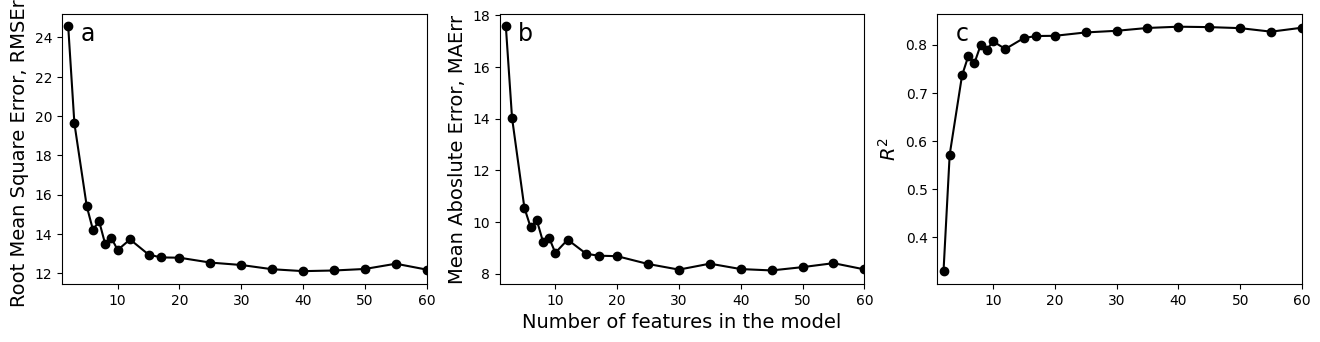

In [14]:
# Plot Metrics as function of the number of features

fig, axs = plt.subplots(1, 3, figsize=(16, 3.5))
axs[0].plot(num_features_to_selects, np.sqrt(mse_feature), 'o-', color='black')
axs[0].set_ylabel('Root Mean Square Error, RMSErr', fontsize=14)
axs[0].set_xlim((1, 60))
axs[0].text(0.05, 0.9, 'a', fontsize=17, transform=axs[0].transAxes)
#axs[0].grid()

axs[1].plot(num_features_to_selects, mae_feature, 'o-', color='black')
axs[1].set_ylabel('Mean Aboslute Error, MAErr', fontsize=14)
axs[1].set_xlim((1, 60))
axs[1].text(0.05, 0.9, 'b', fontsize=17, transform=axs[1].transAxes)
#axs[1].grid()

axs[2].plot(num_features_to_selects, r2_feature, 'o-', color='black')
axs[2].set_ylabel(r'$R^2$' , fontsize=14)
axs[2].set_xlim((1, 60))
axs[2].text(0.05, 0.9, 'c', fontsize=17, transform=axs[2].transAxes)
#axs[2].grid()

axs[1].set_xlabel('Number of features in the model' , fontsize=14)

# Build models for list selected 25 features

In [15]:
N_FEATURES = 25
FEATURES = features_selection[N_FEATURES]
print(f'FEATURES: {FEATURES}')
df_selected = df[FEATURES].copy()

df_es_selected = df_es[FEATURES]
# prepare data for LinearRegression
# remove NaNs
# do one-hot encodings
df_nonans_selected = df_selected.dropna(axis=1)
df_es_nonans_selected = df_es_selected.dropna(axis=1)
no_nans_common_columns = list(set(df_nonans_selected.columns).intersection(df_es_nonans_selected.columns))
df_nonans_selected = df_nonans_selected[no_nans_common_columns]
df_es_nonans_selected = df_es_nonans_selected[no_nans_common_columns]

cat_features_selected = categorical_features(df_selected)
cat_features_nonans_selected = categorical_features(df_nonans_selected)
df_nonans_onehot_selected = pd.get_dummies(df_nonans_selected, columns=cat_features_nonans_selected)
df_es_nonans_onehot_selected = pd.get_dummies(df_es_nonans_selected, columns=cat_features_nonans_selected)

cat_features_nonans_selected = categorical_features(df_nonans_selected)
df_nonans_selected_onehot = pd.get_dummies(df_nonans_selected, columns=cat_features_nonans_selected)

FEATURES: ['BG_dir_up', 'dimer_len', 'h_substrate', 'sr_A1_dyzUP', 'sr_A1_dz2-r2DOWN', 'sr_A2_dz2-r2DOWN', 'sr_A1_dxzUP', 'sr_A1_dosmodeldxzUP_integral_below_1.0', 'sr_A1_dosmodeldxzUP_integral_above_1.0', 'sr_A1_dosmodeldz2-r2DOWN_integral_below_1.0', 'sr_A1_dosmodeldxzDOWN_integral_above_1.0', 'sr_A2_dosmodeldxzDOWN_integral_below_1.0', 'bader_A1', 'bader_A2', 'sr_A1_dosmodeldz2-r2UP_peak_above', 'sr_A1_dosmodeldxzUP_peak_above', 'sr_A1_dosmodeldxyDOWN_E_below', 'sr_A1_dosmodeldx2-y2DOWN_E_below', 'sr_A1_dosmodeldx2-y2DOWN_peak_below', 'sr_A1_dosmodeldyzDOWN_E_above', 'sr_A1_dosmodeldz2-r2DOWN_E_above', 'sr_A1_dosmodeldxzDOWN_E_above', 'sr_A2_dosmodeldx2-y2UP_E_below', 'sr_A2_dosmodeldz2-r2DOWN_E_below', 'PT']


In [16]:
# print selected features in LaTeX format
[labels(f) for f in FEATURES]

['$BG_\\text{dir}^{\\uparrow}$',
 '$d_{len}$',
 '$h_{sub}$',
 '$DOS_{B, d_{yz}}^{\\uparrow}$',
 '$DOS_{B, d_{z^2}}^{\\downarrow}$',
 '$DOS_{T, d_{z^2}}^{\\downarrow}$',
 '$DOS_{B, d_{xz}}^{\\uparrow}$',
 '$I_{B, d_{xz}}^{\\uparrow -}$',
 '$I_{B, d_{xz}}^{\\uparrow +}$',
 '$I_{B, d_{z^2}}^{\\downarrow -}$',
 '$I_{B, d_{xz}}^{\\downarrow +}$',
 '$I_{T, d_{xz}}^{\\downarrow -}$',
 '$q_B$',
 '$q_T$',
 '$D_{B, d_{z^2}}^{\\uparrow +}$',
 '$D_{B, d_{xz}}^{\\uparrow +}$',
 '$E_{B, d_{xy}}^{\\downarrow -}$',
 '$E_{B, d_{x^2-y^2}}^{\\downarrow -}$',
 '$D_{B, d_{x^2-y^2}}^{\\downarrow -}$',
 '$E_{B, d_{yz}}^{\\downarrow +}$',
 '$E_{B, d_{z^2}}^{\\downarrow +}$',
 '$E_{B, d_{xz}}^{\\downarrow +}$',
 '$E_{T, d_{x^2-y^2}}^{\\uparrow -}$',
 '$E_{T, d_{z^2}}^{\\downarrow -}$',
 'PT']

In [17]:
lasso = Lasso(alpha=0.1)
cv_lasso_selected = cross_validate(lasso, df_nonans_selected_onehot, target, cv=5, scoring=scoring,                            
                              return_train_score=True, 
                              return_estimator=True,
                              return_indices=True)

cv_lr_selected = cross_validate(lr,df_nonans_selected_onehot, target, cv=5, scoring=scoring,                            
                              return_train_score=True, 
                              return_estimator=True,
                              return_indices=True)

cb = CatBoostRegressor(verbose=False, cat_features=cat_features_selected)
cv_cb_selected = cross_validate(cb, df_selected, target, cv=5, scoring=scoring, 
                           return_train_score=True, 
                           return_estimator=True,
                           return_indices=True)

In [18]:
nocv_cb_selected = train_nocv(cb, df_selected, target)
nocv_lasso_selected = train_nocv(lasso, df_nonans_selected_onehot, target)
nocv_lr_selected = train_nocv(lr, df_nonans_selected_onehot, target)

In [19]:
csv_path_selected = save_fold_predictions(cv_objs=[cv_lr_selected, cv_lasso_selected, cv_cb_selected],
                                        labels=['MLR', 'LASSO', 'ML'],
                                        dfs=[df_nonans_selected_onehot, df_nonans_selected_onehot, df_selected],
                                        targets=[target, target, target],
                                        filename=f'predictions_fit_selected_features_implicit_withPT',
                                        substrate='implicit')

In [20]:
# Metrics for Implicit Substrates
# Models uses 25 features
compute_metrics_by_method(csv_path_selected, substrate='implicit', filename='Metrics_selected_features_implicit_withPT.txt')

implicit MLR	MAErr=15.9738	RMSErr=22.3543	$R^2$	=0.44
implicit LASSO	MAErr=16.1863	RMSErr=22.6051	$R^2$	=0.43
implicit ML	MAErr=8.2712	RMSErr=12.5021	$R^2$	=0.83


**Conclusion** The above shows that including the PT variable as feature does not improve the predictions of MAE (R2 similar to the model without the PT). This is discussed in the manuscript in lines 406-420.

In [21]:
csv_path_selected_es = save_nofolds_predictions(estimators=[nocv_lr_selected, nocv_lasso_selected, nocv_cb_selected],
                                        labels=['MLR', 'LASSO', 'ML'],
                                        dfs=[df_es_nonans_onehot_selected, df_es_nonans_onehot_selected, df_es_selected],
                                        targets=[target_es, target_es, target_es],
                                        filename=f'predictions_fit_selected_features_explicit_withPT',
                                        substrate='explicit')        

In [23]:
# Metrics for Explicit Substrates
# Models uses 25 features
compute_metrics_by_method(csv_path_selected_es, substrate='explicit', filename='Metrics_selected_features_explicit_withPT.txt')

explicit MLR	MAErr=770.5857	RMSErr=773.4174	$R^2$	=-418.31
explicit LASSO	MAErr=153.6816	RMSErr=158.1194	$R^2$	=-16.53
explicit ML	MAErr=24.4215	RMSErr=30.4069	$R^2$	=0.35
